In [1]:
import os   
import sys
sys.path.append('..')

from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import numpy as np
from tqdm import tqdm

opt = TestOptions().parse(args="""--dataroot /data/sunhwan/pdbbind/refinedset \
                   --csvfile ../../../pdbbind/test.csv \
                   --gpu_ids 0 --batch_size 8 --nThreads 8 \
                   --model gnina_pose --grid_method gnina --grid_size 48 --grid_spacing 0.5 \
                   --channels gnina --dataset_mode pdbbind_docked""".split())
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.checkpoints_dir = '../checkpoints'

------------ Options -------------
aspect_ratio: 1.0
batch_size: 8
channels: gnina
checkpoints_dir: ./checkpoints
csvfile: ../../../pdbbind/test.csv
dataroot: /data/sunhwan/pdbbind/refinedset
dataset_mode: pdbbind_docked
filter_kd: False
gpu_ids: [0]
grid_method: gnina
grid_size: 48.0
grid_spacing: 0.5
how_many: 50
init_type: normal
input_nc: 6
isTrain: False
max_dataset_size: inf
model: gnina_pose
nThreads: 8
n_layers_D: 3
name: experiment_name
no_dropout: False
norm: instance
ntest: inf
phase: test
results_dir: ./results/
rotate: 90
rvdw: 1.4
serial_batches: False
which_epoch: latest
-------------- End ----------------


In [2]:
data_loader = CreateDataLoader(opt)
dataset = data_loader.load_data()
model = create_model(opt)

def correlation(Measure, Fit):
    """Calculates the correlation coefficient R^2 between the two sets
       of Y data provided. Logically, in order for the result to have a sense
       you want both Y arrays to have been created from the same X array.""" 
                    
    Mean = np.mean(Measure)
    s1 = 0          
    s2 = 0          
    Size = np.size(Measure) # identical to np.size(Fit)

    for i in range(0, Size):
        s1 += (Measure[i] - Fit[i]) ** 2
        s2 += (Measure[i] - Mean) ** 2
    Rsquare = 1 - s1/s2
    return Rsquare 
                   
# test


CustomDatasetDataLoader
dataset [PdbBindDataset] was created
gnina_pose
initialization method [normal]
---------- Networks initialized -------------
-----------------------------------------------
model [GninaPoseModel] was created


/home/sunhwan/work/pdbbind/deep/deep-bs/models/networks.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)
/home/sunhwan/work/pdbbind/deep/deep-bs/models/networks.py:19: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)


In [ ]:
# test      
preds_pose = np.zeros(len(dataset))
trues_pose = np.zeros(len(dataset))
preds_affinity = np.zeros(len(dataset))
trues_affinity = np.zeros(len(dataset))
with tqdm(total=int(len(dataset)/opt.batch_size)+1) as pbar:
    for i, data in enumerate(dataset):
        model.set_input(data)
        model.test()
        offset = i * opt.batch_size
        preds_pose[offset:offset+opt.batch_size] = model.preds_pose.cpu().detach().numpy().flatten()
        trues_pose[offset:offset+opt.batch_size] = data['pose'].flatten()
        preds_affinity[offset:offset+opt.batch_size] = model.preds_affinity.cpu().detach().numpy().flatten()
        trues_affinity[offset:offset+opt.batch_size] = data['affinity'].flatten()
        pbar.update()


  0%|          | 0/968 [00:00<?, ?it/s]/home/sunhwan/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
 23%|██▎       | 227/968 [11:41<17:33,  1.42s/it]  

In [8]:
import torch

In [9]:
loss = torch.nn.SmoothL1Loss()

In [10]:
loss(model.preds_affinity, data['affinity'].cuda())

tensor(1.1758, device='cuda:0', grad_fn=<SmoothL1LossBackward>)

In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [12]:
mask = np.where(trues_pose)
print("corr coef:", np.corrcoef(preds_affinity[mask], trues_affinity[mask])[0,1])
print("R2:", correlation(trues_affinity[mask], preds_affinity[mask]))

corr coef: 0.7056008086569301
R2: 0.49191216783943936


In [13]:
print("corr coef:", np.corrcoef(preds_pose, trues_pose)[0,1])
print("R2:", correlation(trues_pose, preds_pose))

corr coef: 0.9673911967810619
R2: 0.9355718505941447


In [14]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

Text(0.5, 0, '-Log10(Kd)')

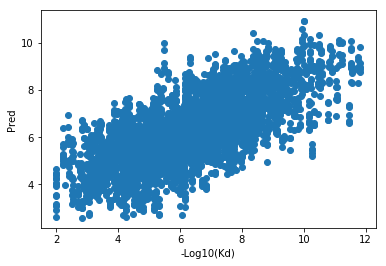

In [15]:
plt.scatter(trues_affinity[mask], preds_affinity[mask])
plt.ylabel('Pred')
plt.xlabel('-Log10(Kd)')

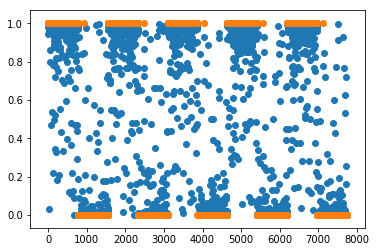

In [25]:
x = np.arange(len(preds_pose))
y = preds_pose
y2 = trues_pose
plt.scatter(x, y)
plt.scatter(x, y2)

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

In [19]:
fpr, tpr, threshold = roc_curve(trues_pose, preds_pose)
score = roc_auc_score(trues_pose, preds_pose)
print(score)

0.9980165421691775


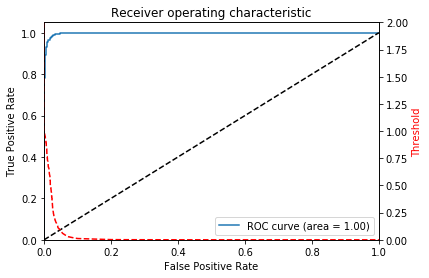

In [24]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, threshold, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([threshold[-1],threshold[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
 
#plt.savefig('roc_and_threshold.png')
#plt.close()
plt.show()

In [36]:
th = 0.25
idx = np.argwhere(threshold < th).flatten()[0]
fpr[idx], tpr[idx]

(0.027684346701164295, 0.9889032258064516)

In [35]:
roc_curve?

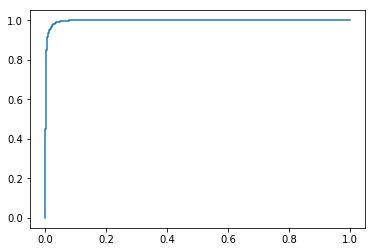

In [36]:
plt.plot(fpr, tpr)

In [2]:
import pandas as pd
csvfile = '../jak2-test/output.csv'
output = pd.read_csv(csvfile)

In [3]:
output.head()

,true,pred
0,3.960000,6.885036
1,7.447650,7.869942
2,6.087254,9.412878
3,7.142523,8.996725
4,7.477314,6.976058


In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

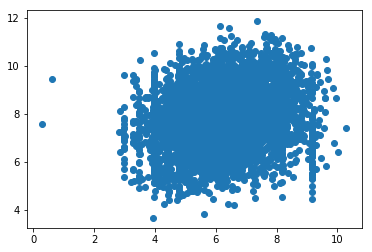

In [6]:
plt.scatter(output.true, output.pred)